In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np 
import pandas as pd 
import os
import cv2
import matplotlib.pyplot as plt

#### 레이블

In [3]:
labels = os.listdir("/content/drive/MyDrive/D.D.D./train")
labels

['Closed', 'yawn', 'Open', 'no_yawn']

#### 이미지 불러와서 저장하기

In [4]:
def get_data(dir_path="/content/drive/MyDrive/D.D.D./train/", 
             face_cas="/content/drive/MyDrive/D.D.D./haarcascade_frontalface_default.xml", 
             eye_cas="/content/drive/MyDrive/D.D.D./haarcascade_eye.xml"):
    labels = ['Closed', 'Open']
    IMG_SIZE = 145
    data = []
    for label in labels:
        path = os.path.join(dir_path, label)
        class_num = labels.index(label)
       # class_num +=2
        print(class_num)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)   ### 변경1
                resized_array = cv2.resize(img_array, (34, 26))                         ### 변경2
                data.append([resized_array, class_num])
            except Exception as e:
                print(e)
    return data

In [5]:
data_train = get_data()

0
1


#### 레이블과 이미지 분류

In [6]:
X = []
y = []
for feature, label in data_train:
    X.append(feature)
    y.append(label)

In [7]:
import numpy as np
X = np.array(X)
y = np.array(y)

In [8]:
from sklearn.preprocessing import LabelBinarizer
label_bin = LabelBinarizer()
y = label_bin.fit_transform(y)

In [9]:
X = X.reshape(1452, 26, 34,1)    ### 변경3

In [10]:
from sklearn.model_selection import train_test_split
seed = 42
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

In [30]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1016, 26, 34, 1)
(436, 26, 34, 1)
(1016, 1)
(436, 1)


#### train

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision.transforms import transforms
import torch.optim as optim

In [12]:
from torch.utils.data import Dataset
import torch


class eyes_dataset(Dataset):
    def __init__(self, x_file_paths, y_file_path, transform=None):
        self.x_files = x_file_paths
        self.y_files = y_file_path
        self.transform = transform

    def __getitem__(self, idx):
        x = self.x_files[idx]
        x = torch.from_numpy(x).float()   ##tensor로 변환하는거 아닌가..?

        y = self.y_files[idx]
        y = torch.from_numpy(y).float()

        return x, y

    def __len__(self):
        return len(self.x_files)

In [13]:
train_dataset = eyes_dataset(X_train, y_train)    ### 변경4

In [14]:
type(y_train) 

numpy.ndarray

#### 모델 훈련하기

In [15]:
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(1536, 512)
        self.fc2 = nn.Linear(512, 1)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)),2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        x = x.reshape(-1, 1536)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)


        return x

In [16]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)

In [17]:
model = Net()
model.to('cuda')

#os.environ["CUDA_VISIBLE_DEVICES"]

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

epochs = 50

In [18]:
def accuracy(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum / y_test.shape[0]
    acc = torch.round(acc * 100)

    return acc

In [19]:
for epoch in range(epochs):
    running_loss = 0.0
    running_acc = 0.0

    model.train()

    for i, data in enumerate(train_dataloader, 0):
        input_1, labels = data[0].to('cuda'), data[1].to('cuda')

        input = input_1.transpose(1, 3).transpose(2, 3)

        optimizer.zero_grad()

        outputs = model(input)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_acc += accuracy(outputs, labels)

        if i % 80 == 79:
            print('epoch: [%d/%d] train_loss: %.5f train_acc: %.5f' % (
                epoch + 1, epochs, running_loss / 80, running_acc / 80))
            running_loss = 0.0

print("learning finish")      ##하드웨어에 맞게 batch size를 변경해야 결과가 나옵니다. 

epoch: [1/50] train_loss: 0.86297 train_acc: 72.72500
epoch: [2/50] train_loss: 0.23629 train_acc: 90.16250
epoch: [3/50] train_loss: 0.12463 train_acc: 96.05000
epoch: [4/50] train_loss: 0.10273 train_acc: 96.83750
epoch: [5/50] train_loss: 0.08100 train_acc: 97.60000
epoch: [6/50] train_loss: 0.06170 train_acc: 98.33750
epoch: [7/50] train_loss: 0.08486 train_acc: 97.10000
epoch: [8/50] train_loss: 0.05928 train_acc: 98.18750
epoch: [9/50] train_loss: 0.02789 train_acc: 99.08750
epoch: [10/50] train_loss: 0.02707 train_acc: 99.10000
epoch: [11/50] train_loss: 0.03132 train_acc: 98.48750
epoch: [12/50] train_loss: 0.04705 train_acc: 98.17500
epoch: [13/50] train_loss: 0.01237 train_acc: 100.00000
epoch: [14/50] train_loss: 0.01506 train_acc: 99.40000
epoch: [15/50] train_loss: 0.00875 train_acc: 99.85000
epoch: [16/50] train_loss: 0.00498 train_acc: 100.00000
epoch: [17/50] train_loss: 0.00226 train_acc: 100.00000
epoch: [18/50] train_loss: 0.00329 train_acc: 100.00000
epoch: [19/50] 

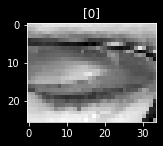

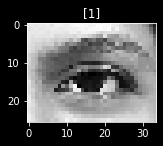

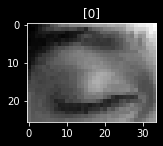

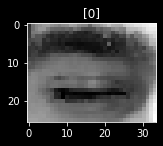

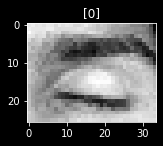

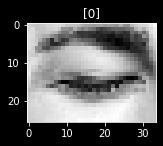

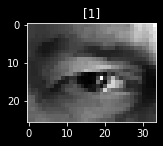

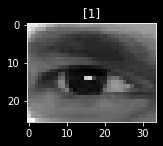

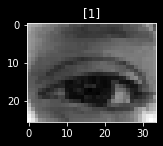

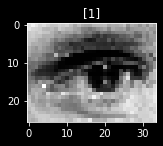

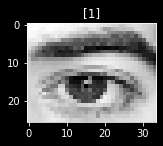

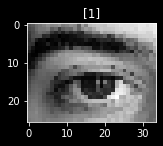

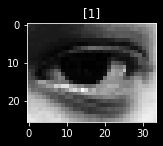

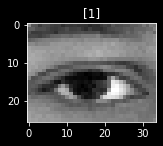

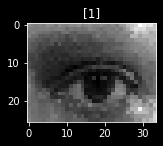

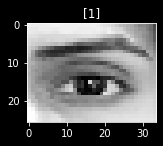

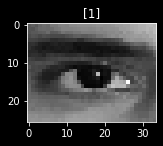

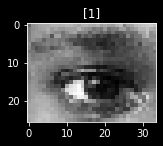

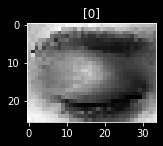

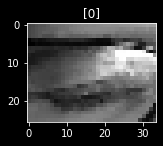

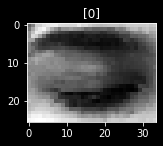

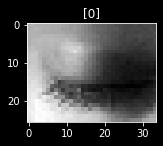

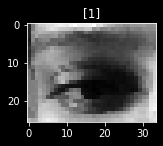

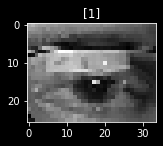

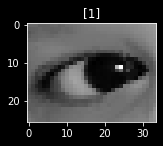

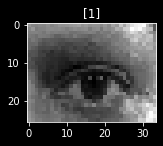

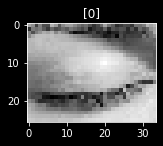

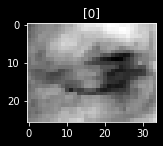

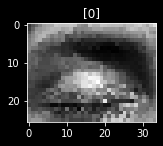

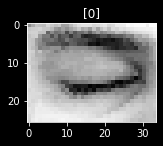

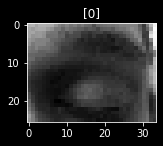

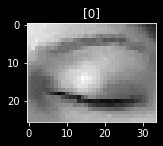

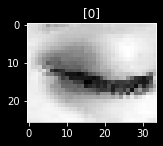

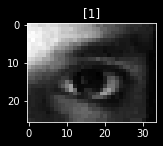

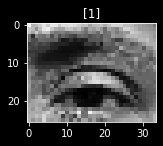

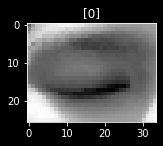

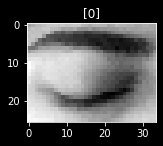

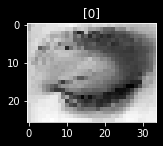

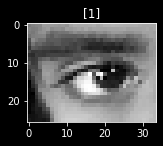

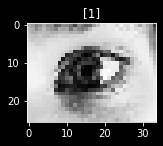

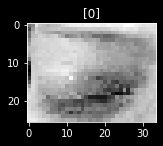

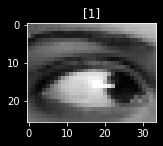

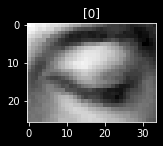

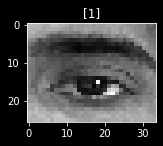

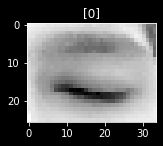

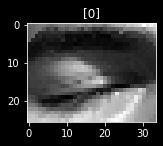

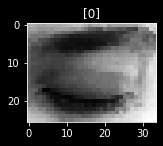

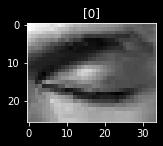

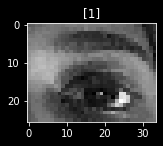

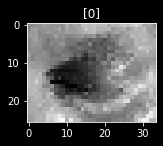

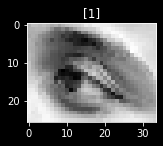

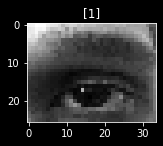

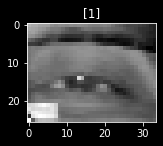

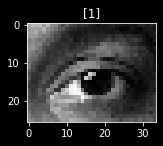

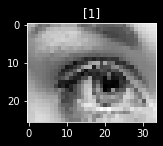

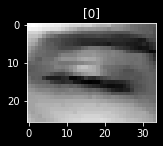

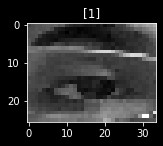

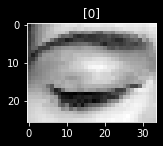

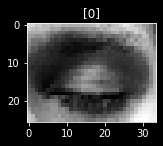

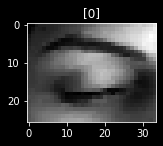

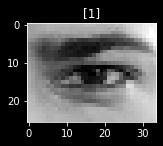

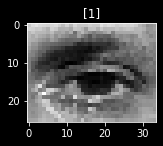

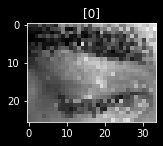

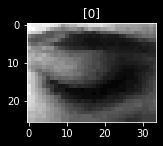

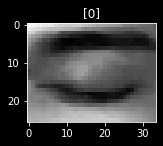

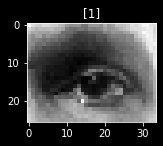

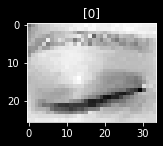

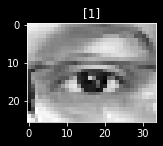

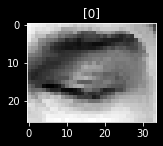

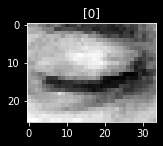

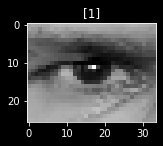

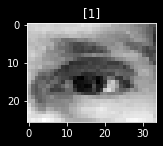

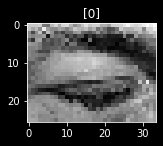

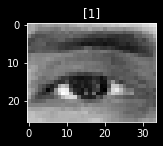

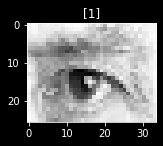

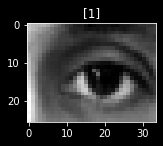

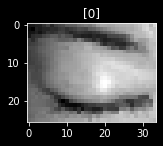

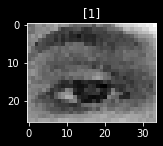

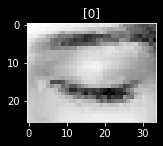

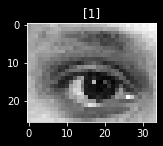

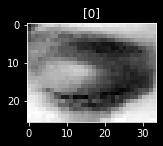

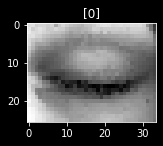

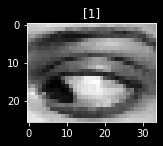

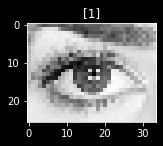

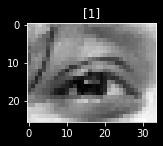

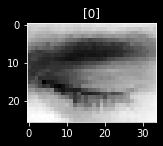

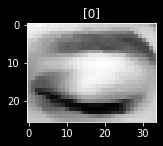

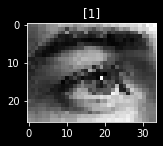

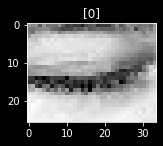

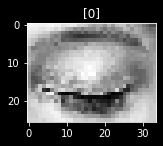

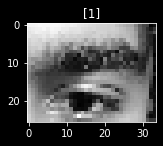

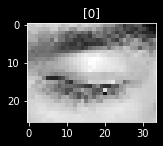

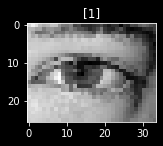

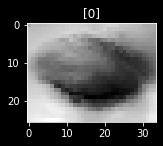

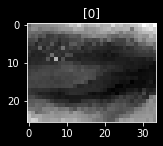

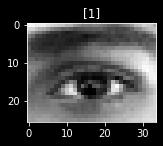

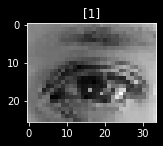

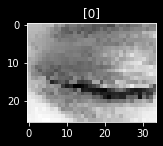

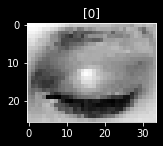

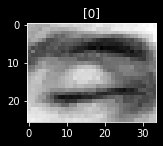

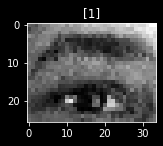

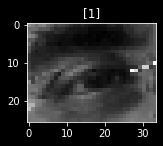

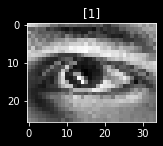

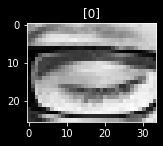

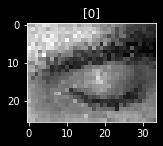

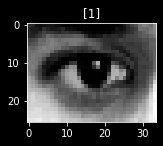

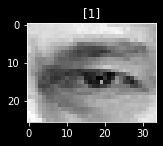

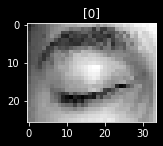

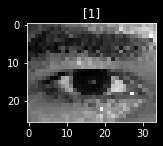

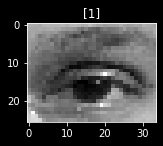

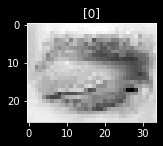

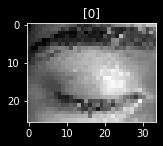

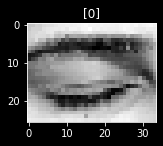

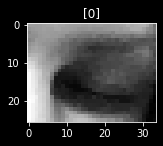

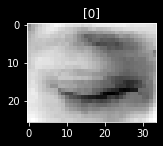

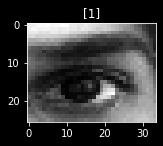

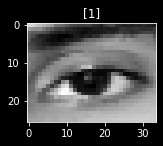

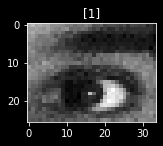

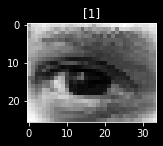

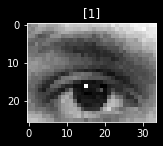

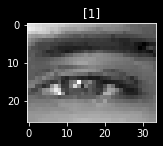

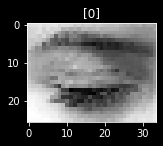

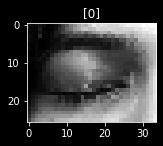

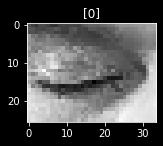

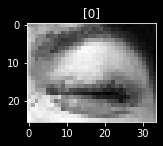

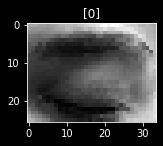

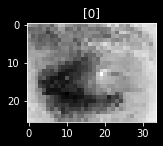

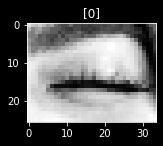

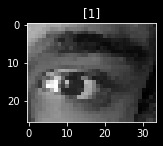

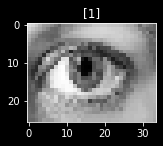

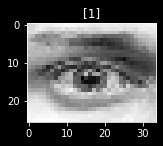

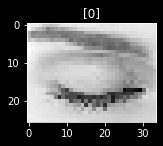

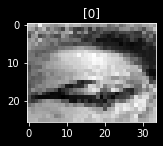

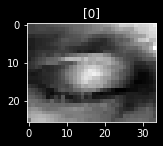

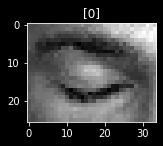

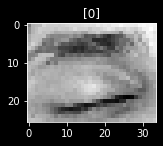

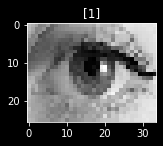

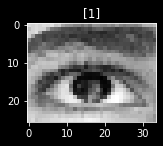

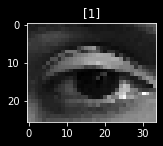

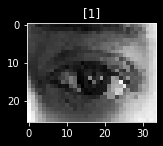

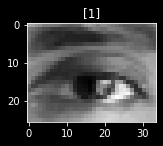

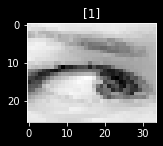

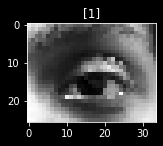

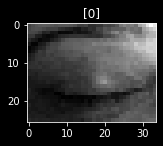

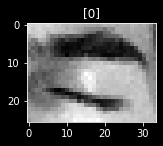

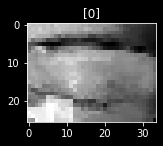

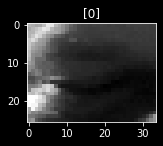

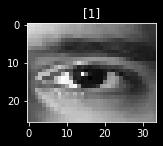

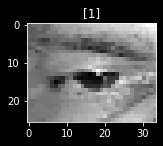

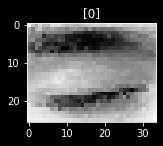

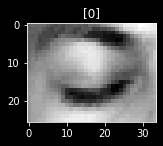

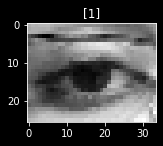

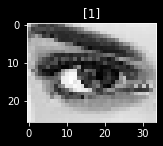

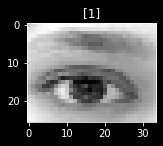

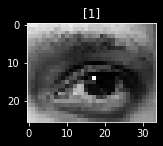

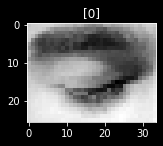

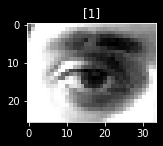

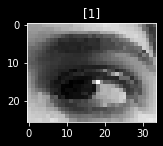

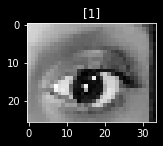

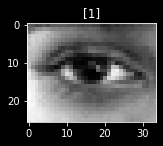

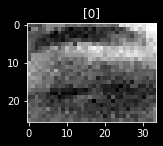

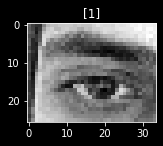

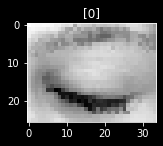

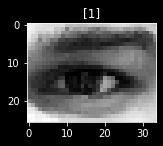

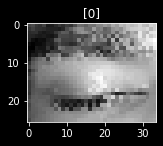

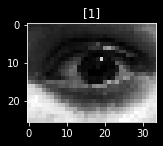

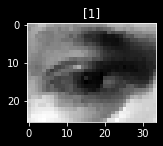

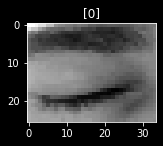

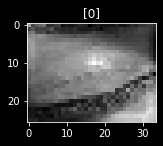

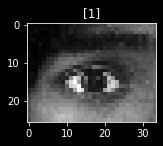

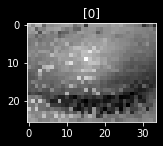

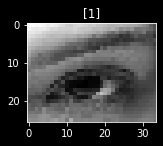

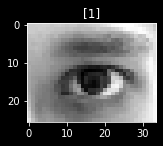

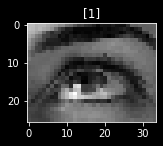

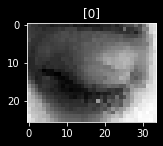

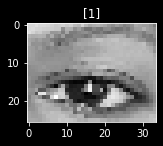

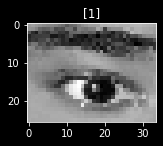

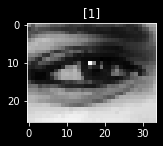

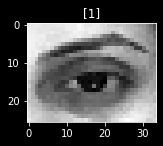

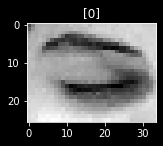

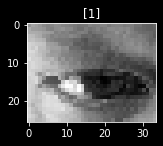

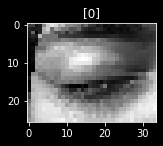

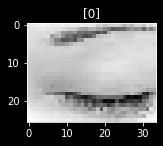

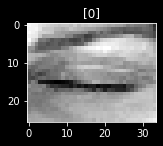

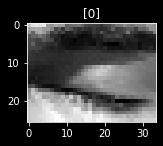

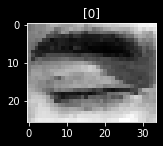

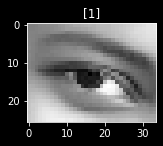

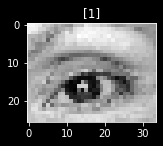

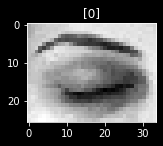

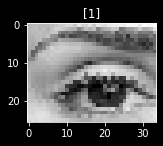

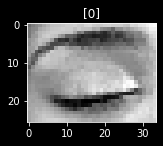

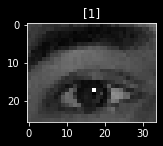

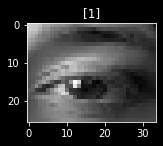

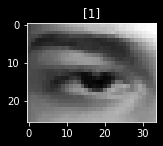

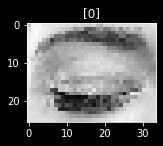

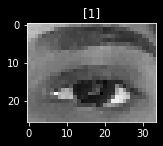

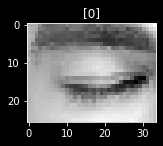

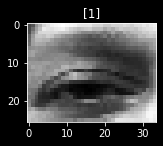

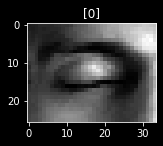

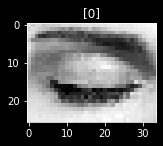

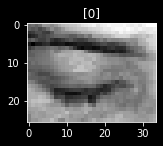

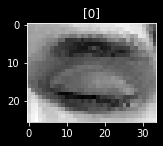

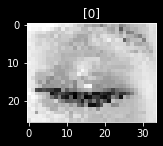

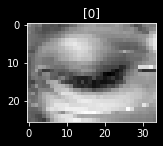

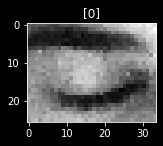

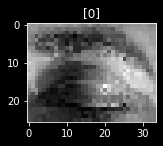

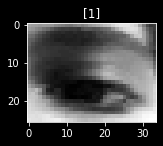

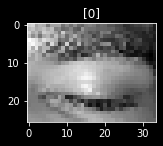

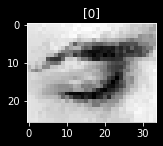

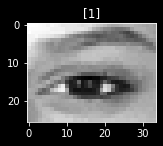

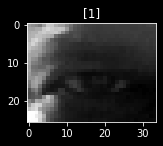

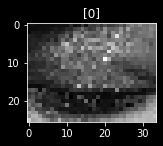

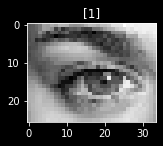

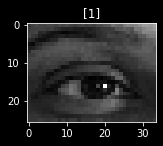

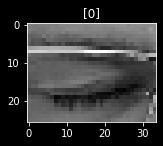

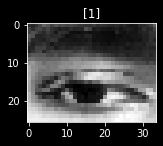

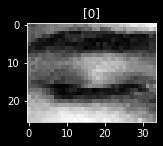

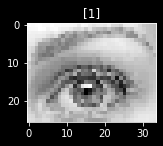

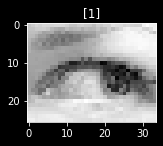

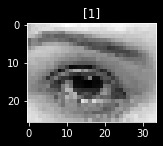

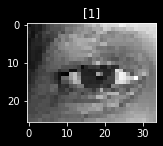

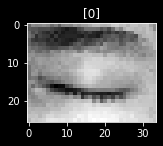

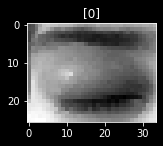

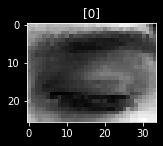

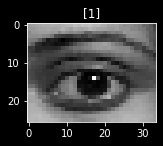

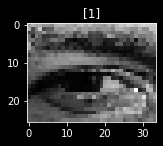

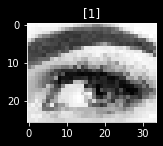

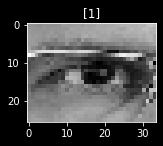

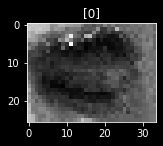

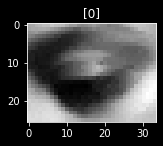

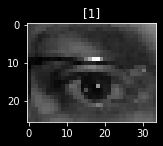

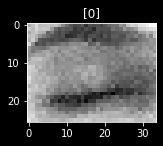

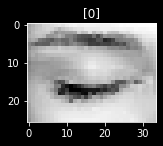

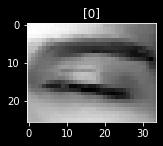

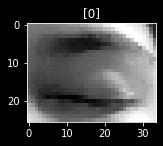

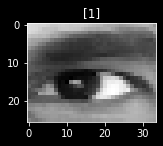

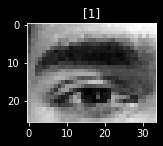

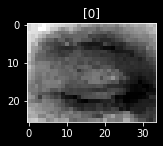

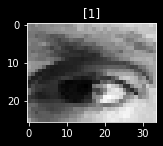

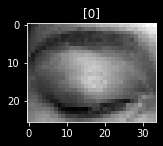

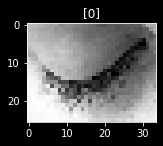

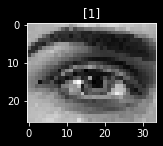

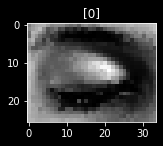

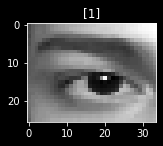

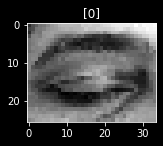

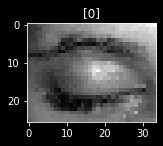

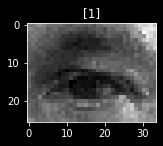

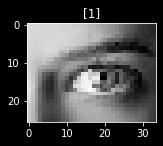

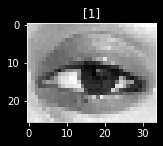

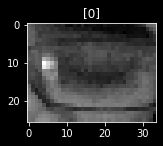

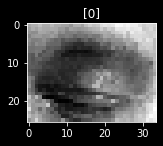

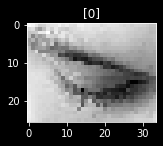

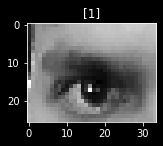

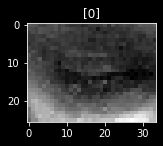

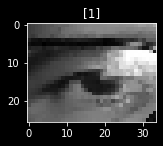

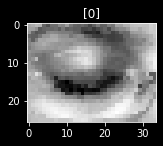

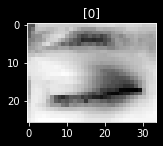

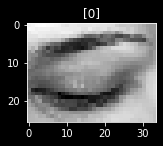

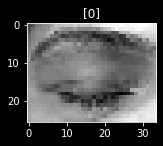

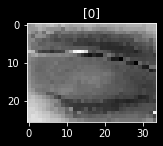

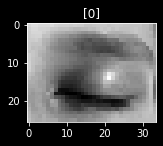

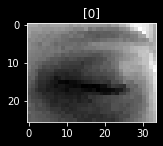

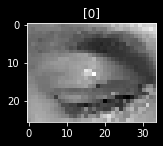

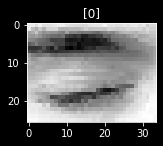

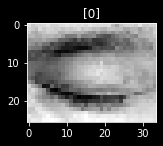

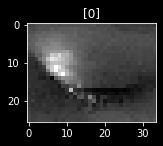

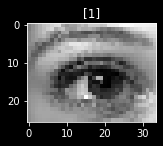

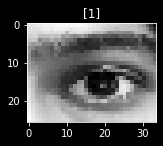

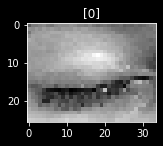

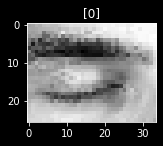

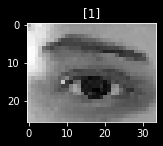

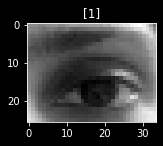

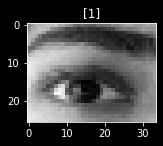

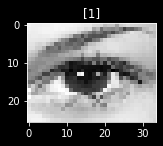

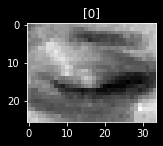

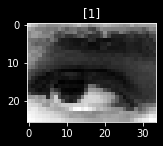

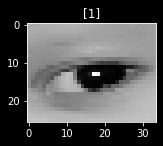

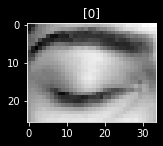

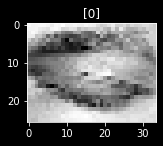

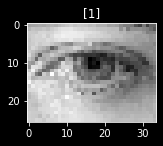

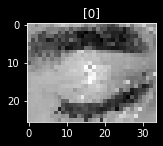

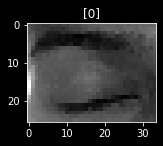

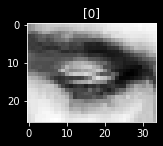

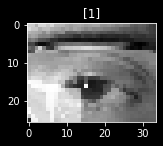

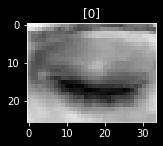

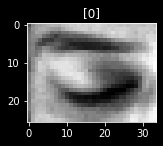

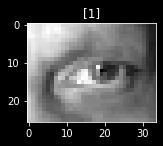

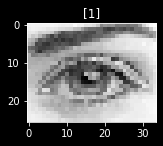

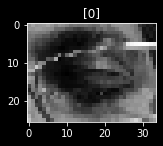

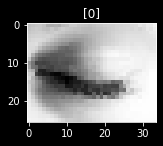

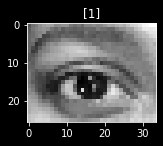

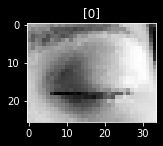

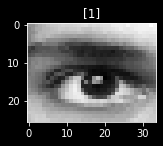

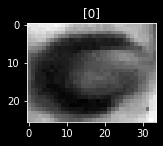

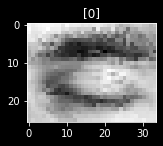

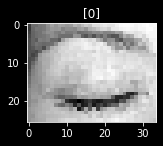

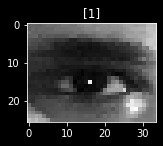

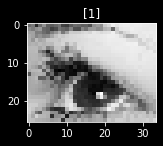

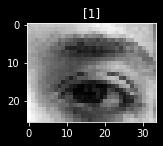

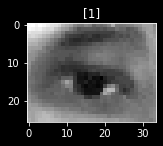

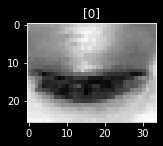

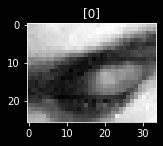

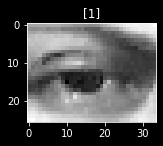

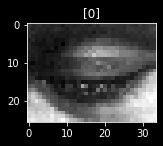

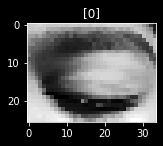

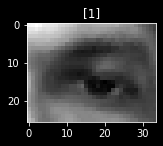

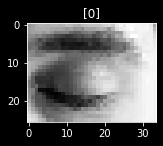

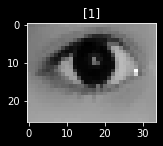

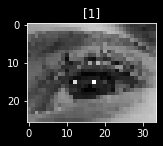

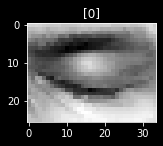

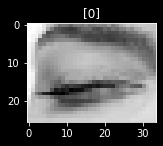

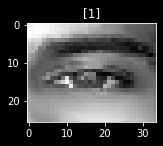

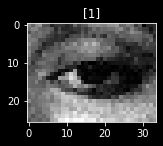

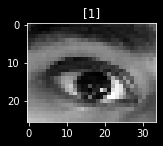

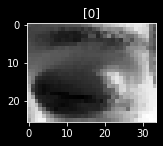

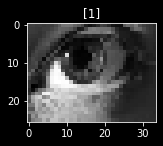

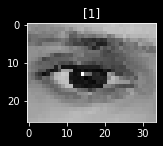

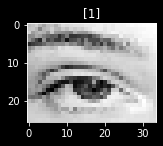

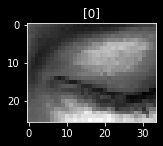

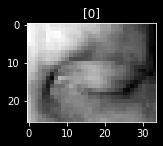

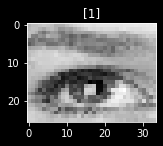

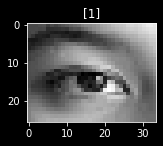

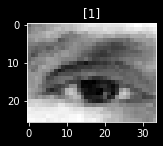

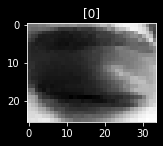

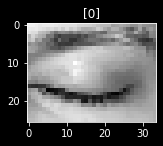

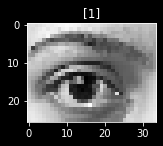

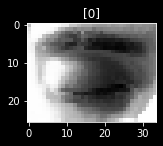

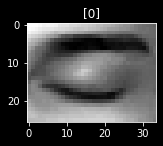

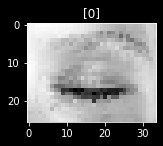

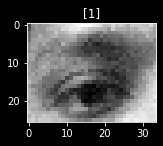

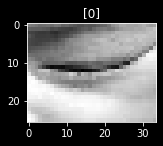

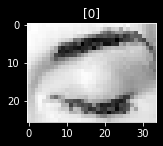

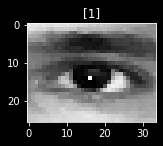

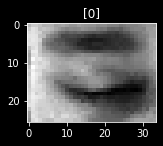

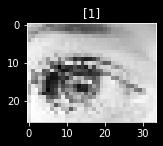

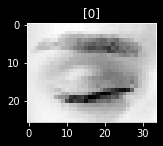

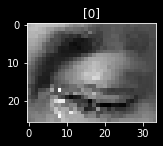

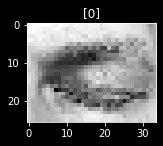

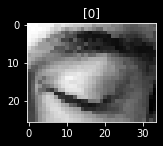

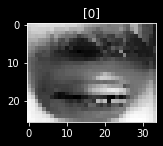

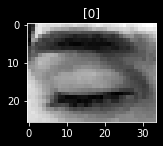

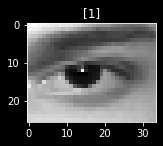

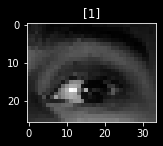

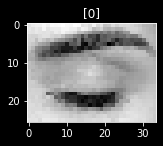

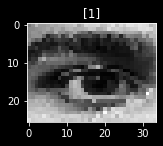

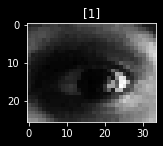

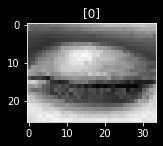

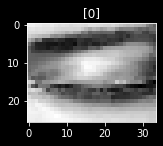

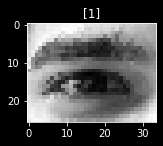

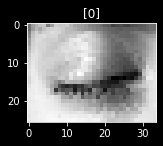

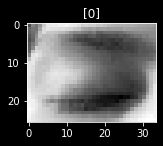

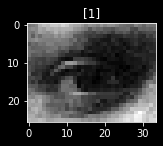

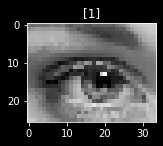

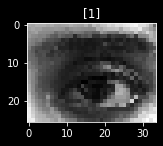

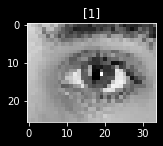

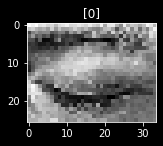

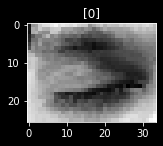

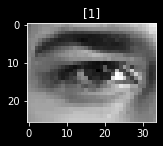

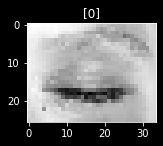

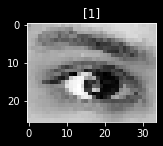

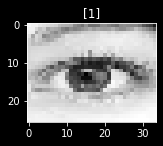

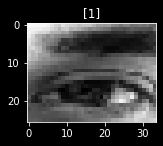

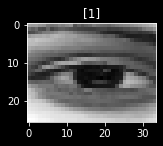

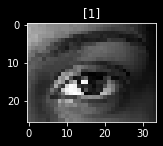

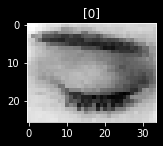

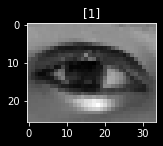

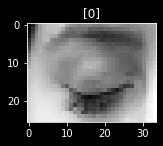

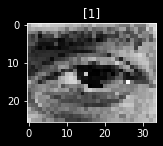

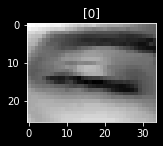

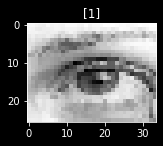

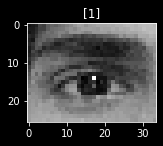

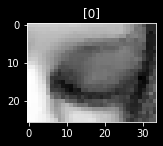

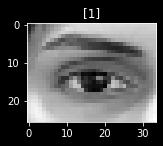

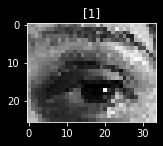

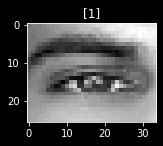

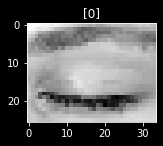

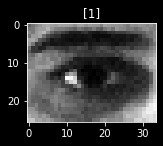

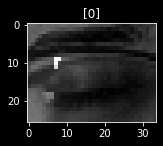

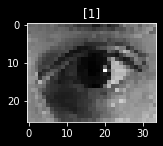

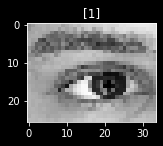

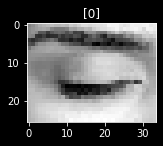

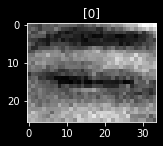

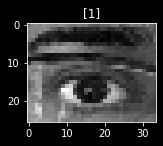

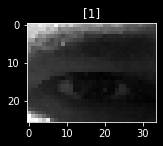

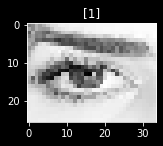

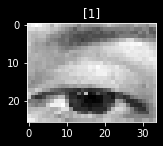

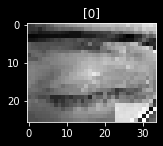

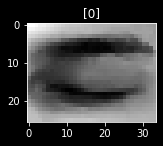

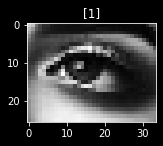

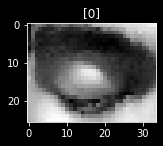

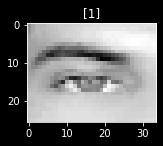

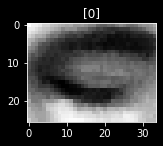

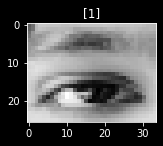

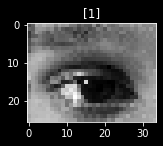

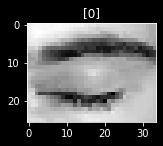

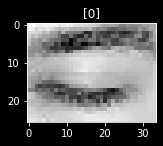

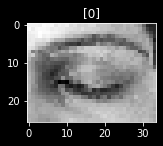

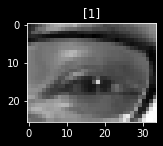

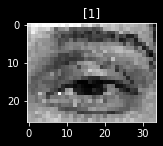

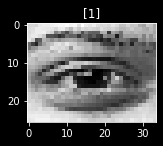

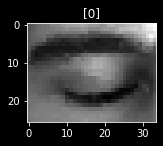

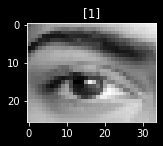

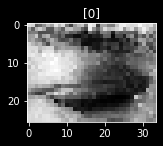

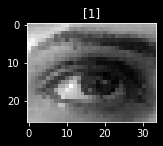

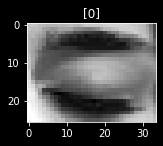

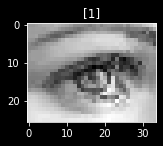

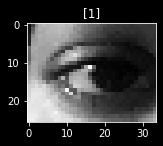

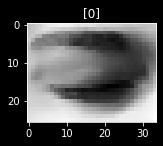

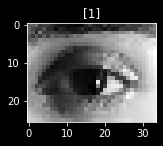

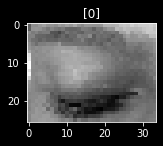

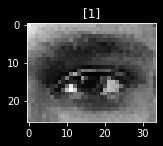

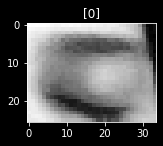

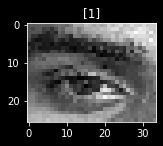

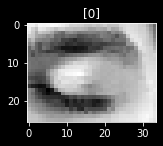

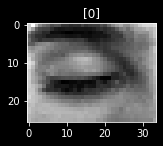

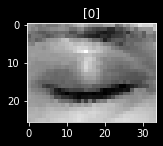

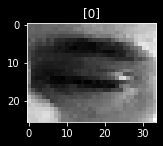

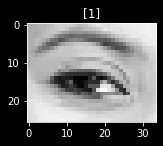

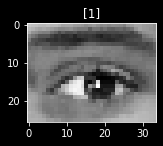

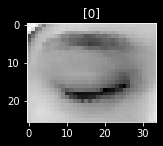

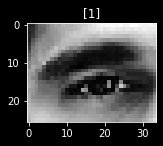

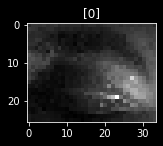

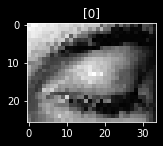

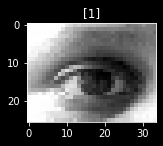

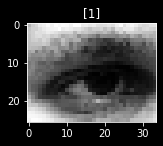

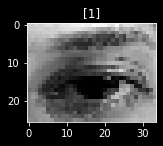

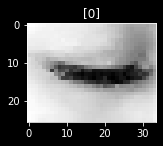

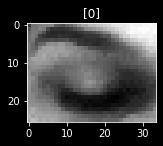

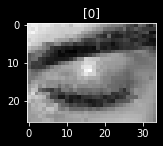

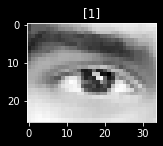

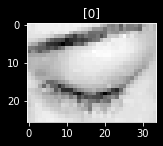

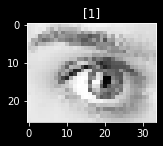

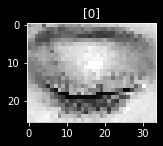

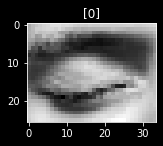

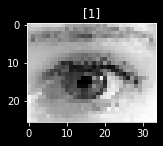

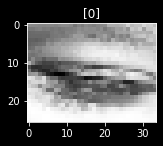

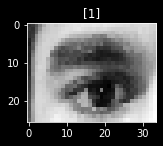

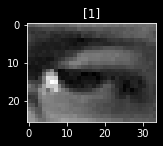

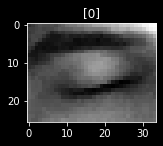

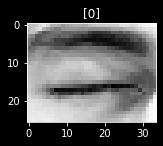

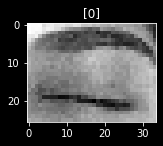

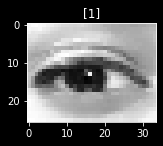

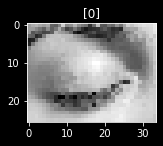

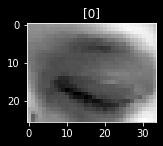

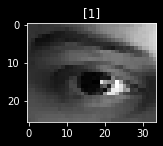

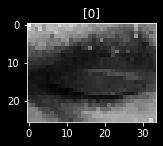

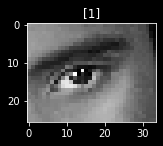

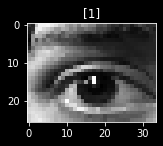

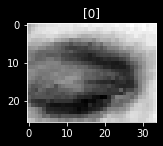

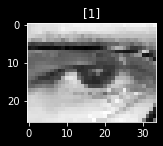

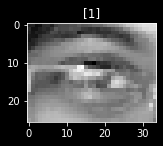

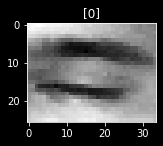

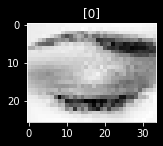

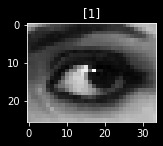

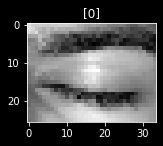

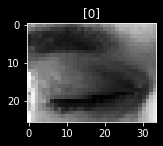

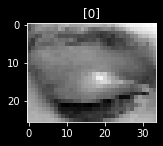

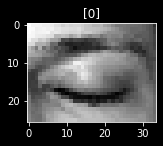

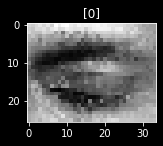

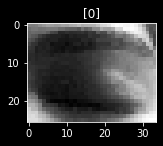

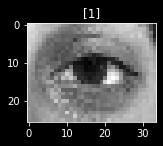

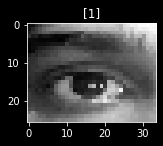

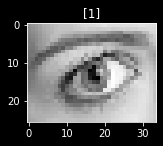

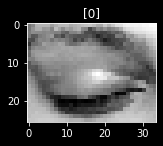

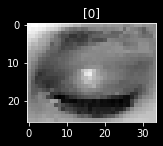

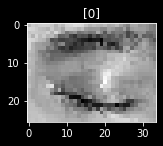

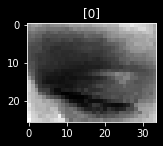

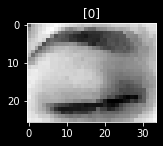

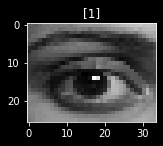

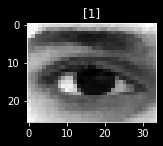

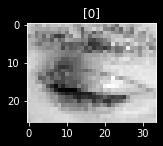

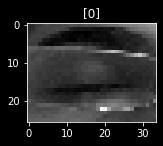

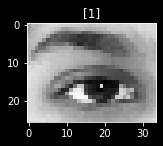

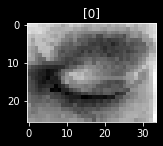

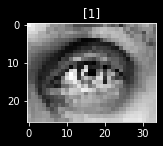

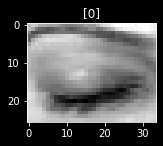

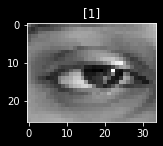

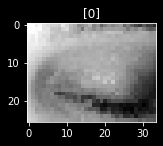

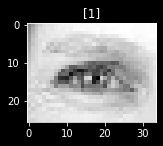

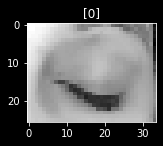

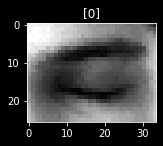

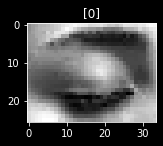

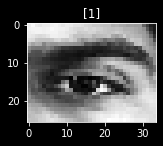

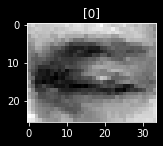

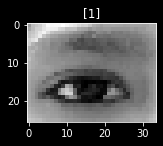

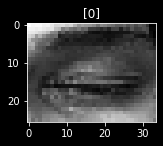

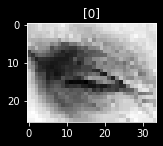

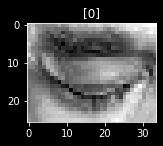

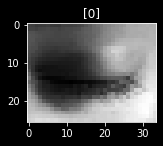

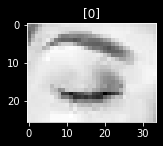

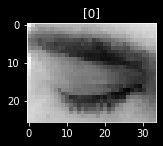

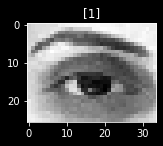

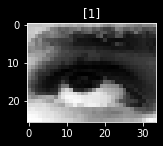

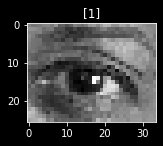

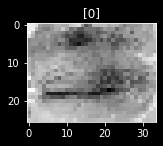

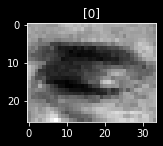

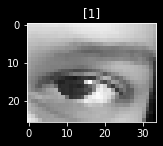

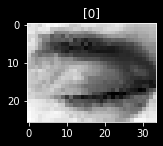

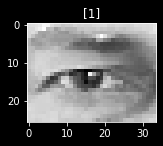

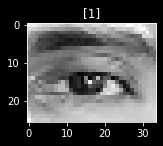

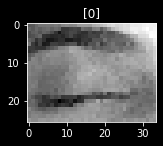

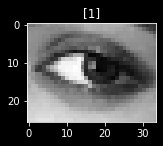

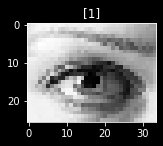

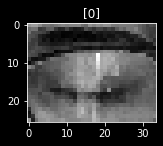

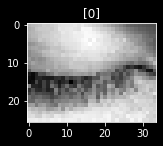

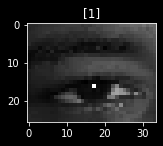

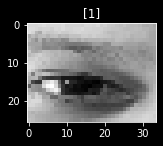

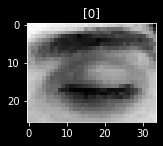

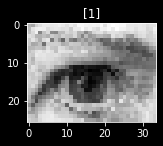

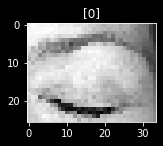

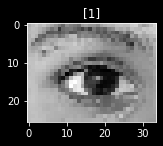

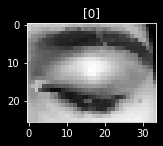

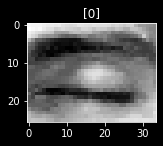

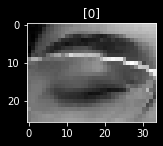

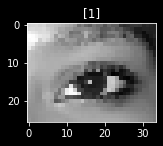

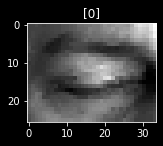

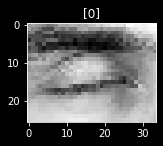

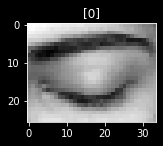

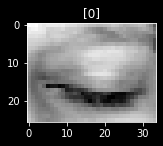

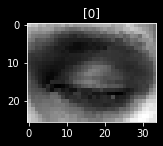

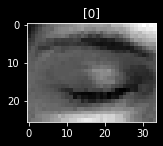

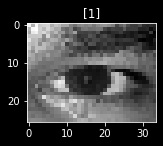

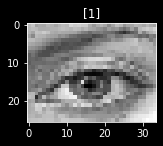

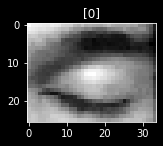

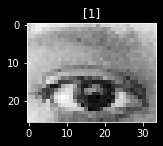

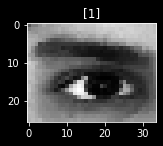

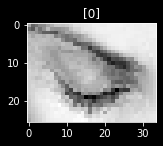

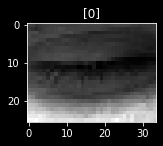

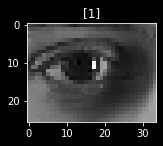

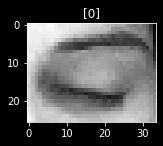

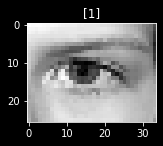

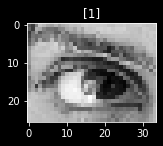

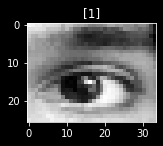

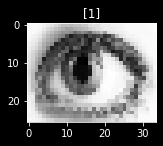

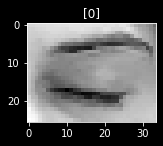

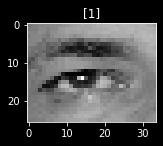

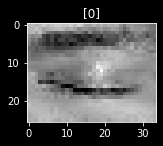

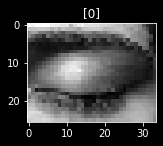

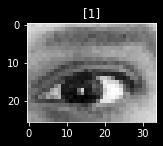

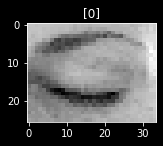

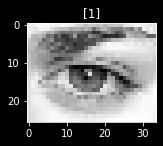

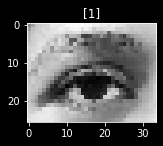

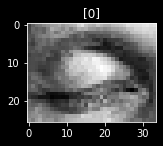

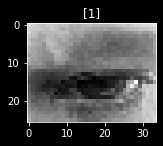

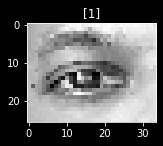

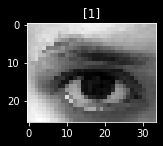

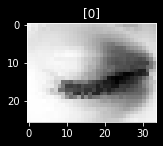

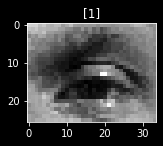

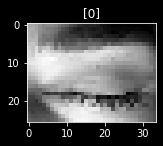

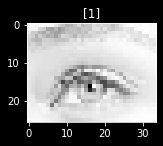

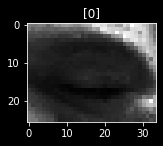

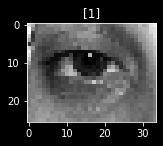

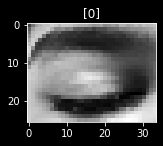

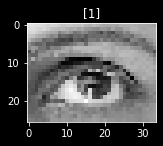

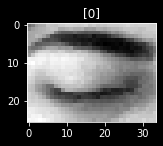

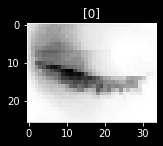

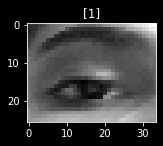

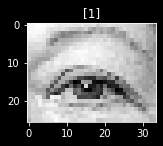

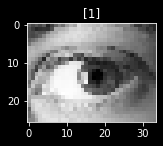

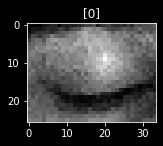

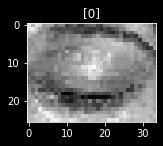

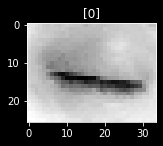

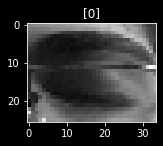

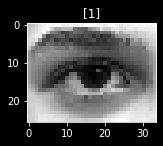

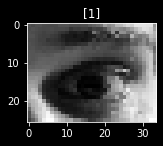

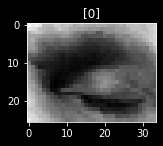

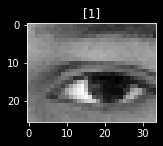

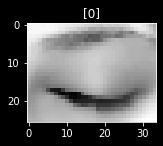

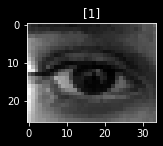

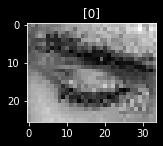

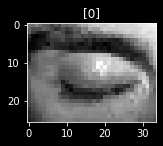

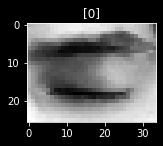

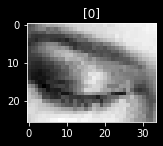

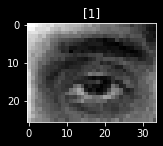

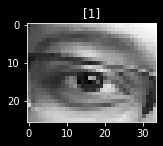

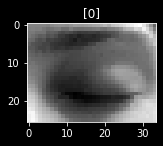

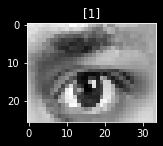

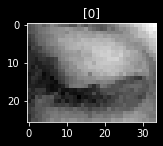

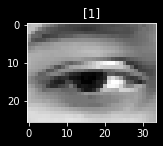

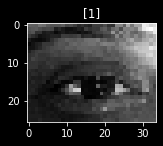

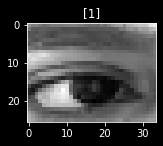

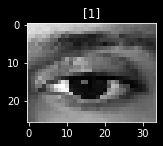

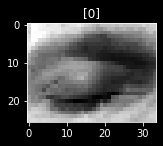

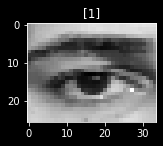

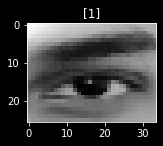

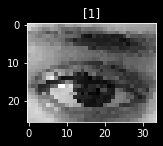

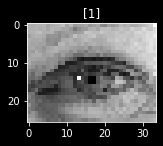

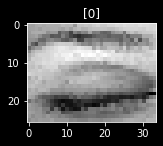

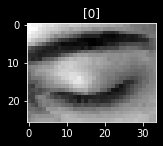

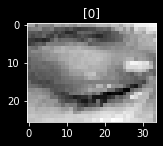

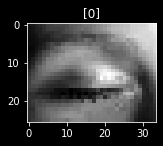

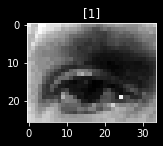

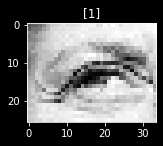

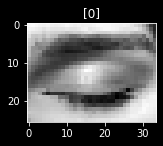

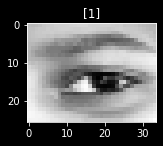

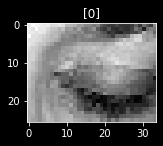

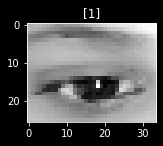

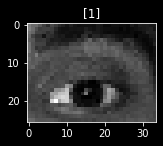

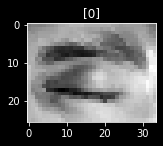

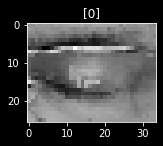

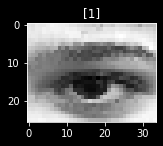

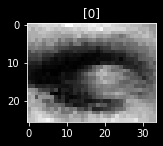

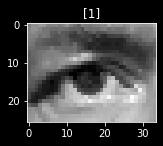

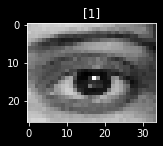

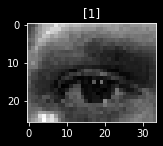

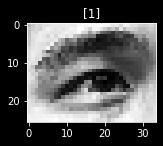

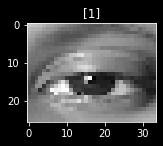

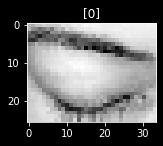

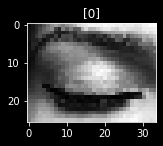

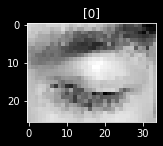

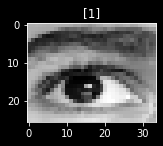

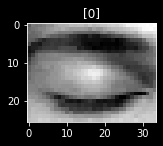

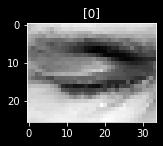

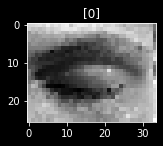

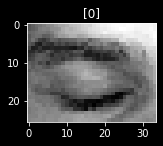

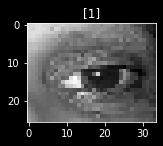

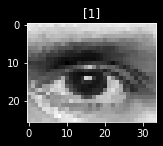

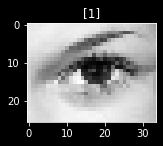

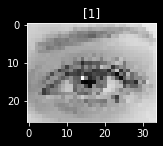

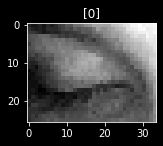

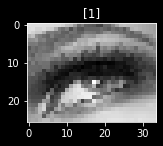

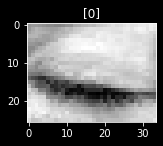

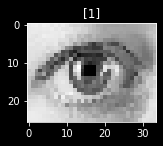

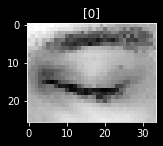

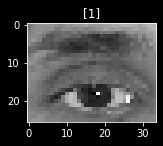

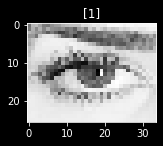

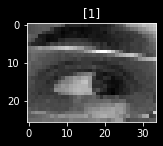

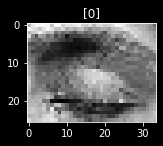

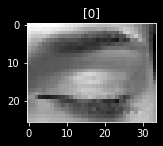

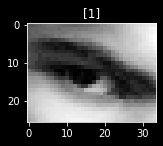

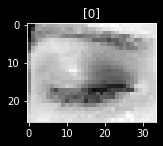

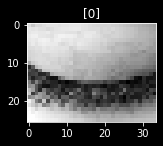

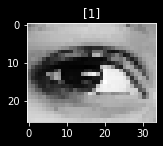

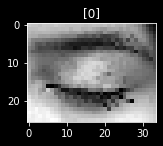

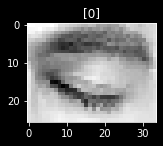

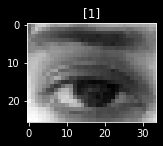

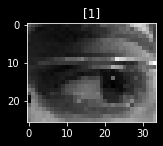

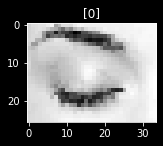

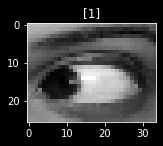

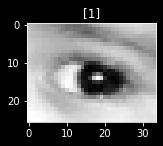

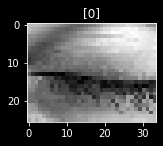

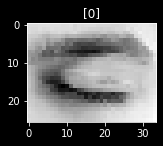

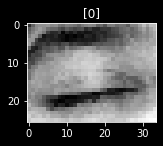

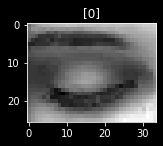

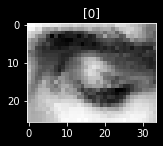

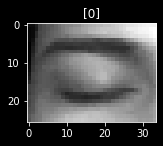

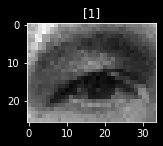

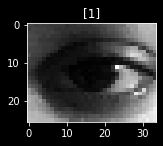

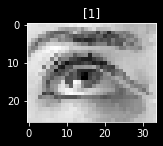

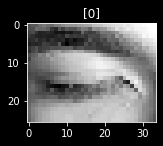

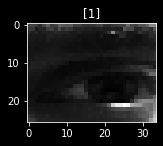

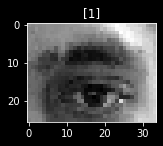

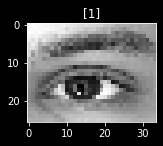

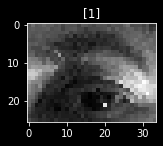

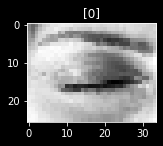

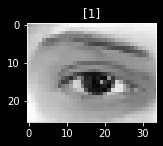

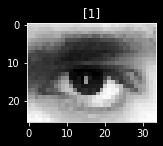

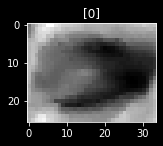

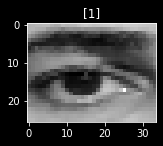

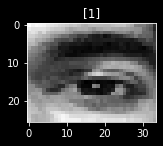

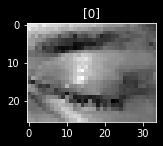

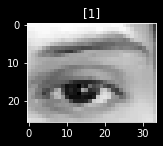

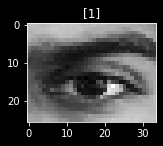

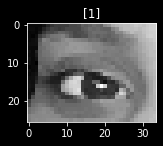

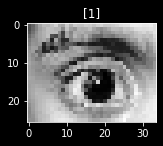

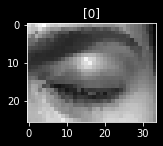

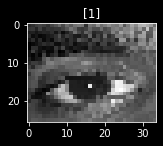

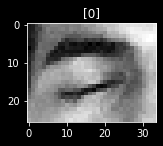

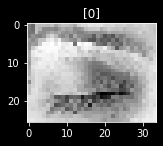

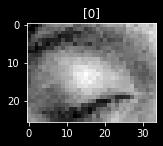

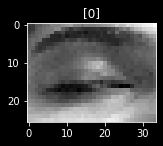

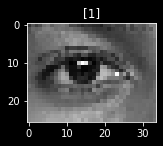

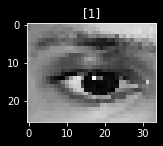

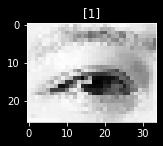

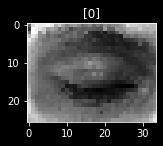

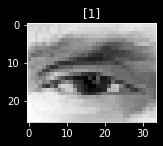

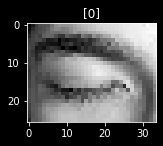

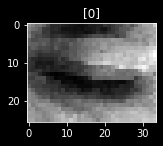

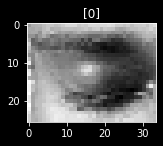

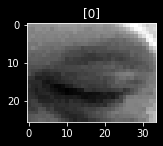

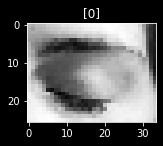

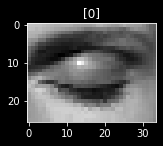

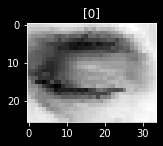

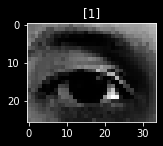

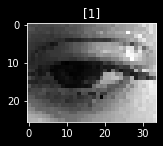

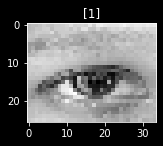

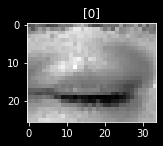

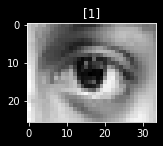

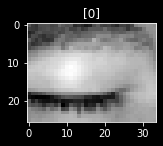

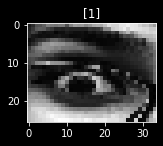

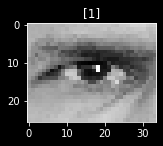

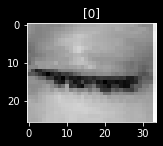

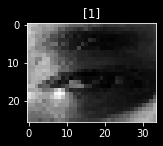

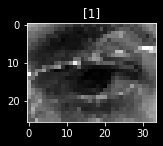

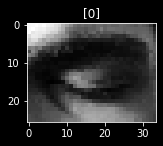

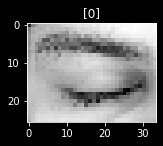

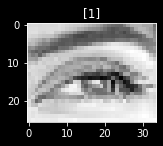

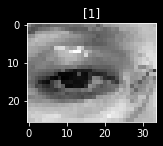

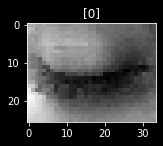

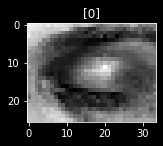

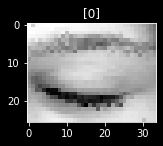

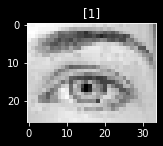

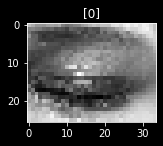

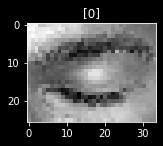

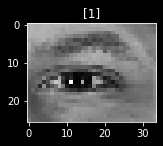

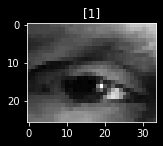

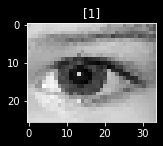

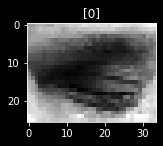

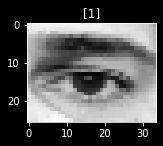

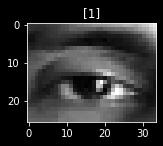

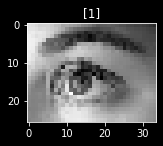

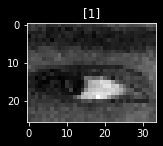

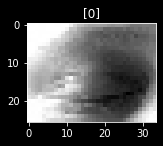

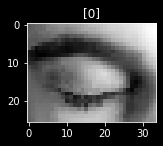

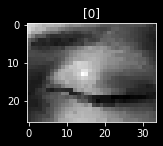

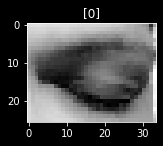

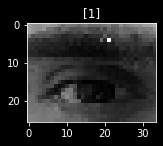

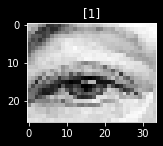

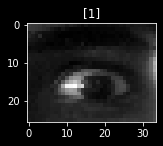

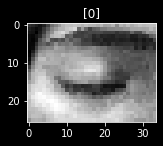

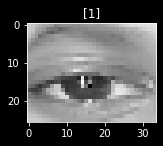

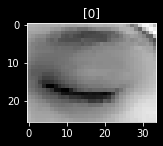

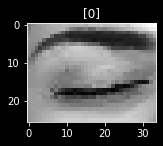

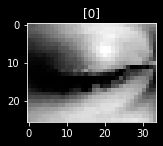

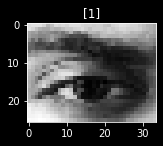

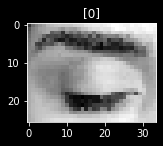

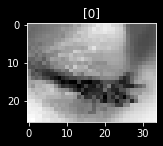

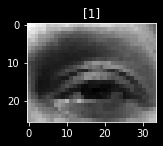

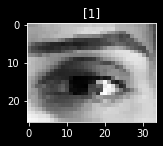

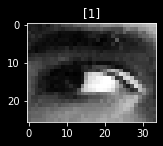

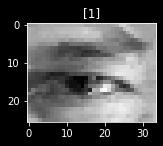

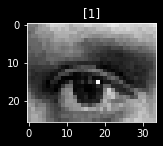

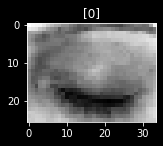

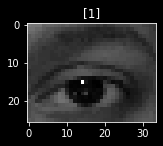

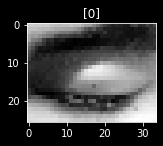

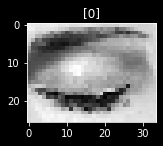

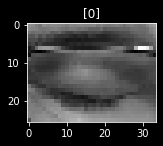

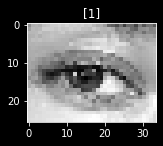

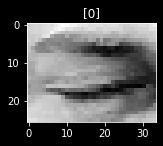

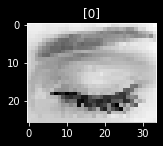

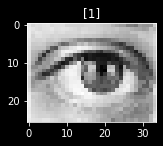

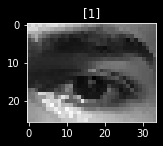

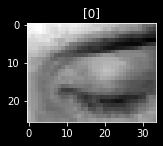

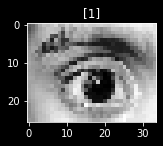

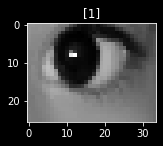

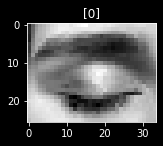

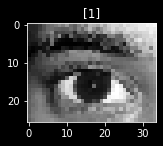

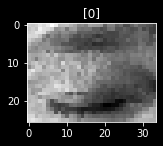

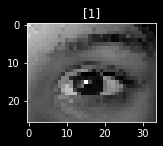

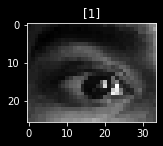

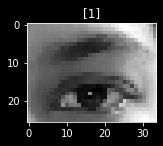

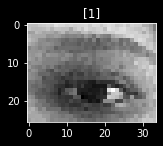

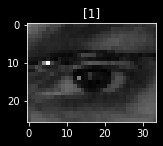

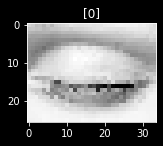

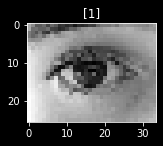

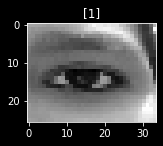

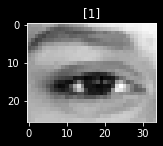

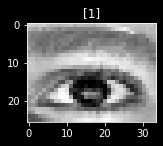

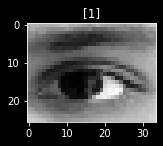

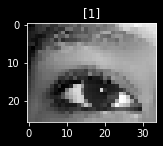

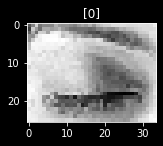

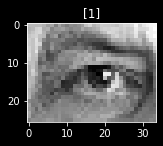

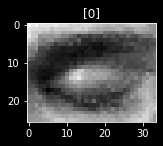

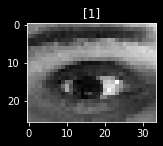

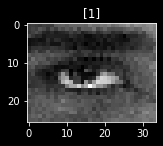

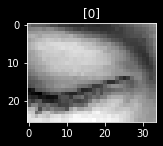

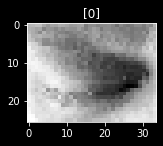

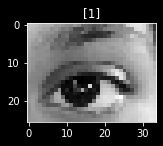

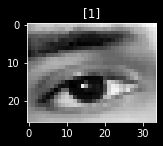

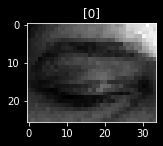

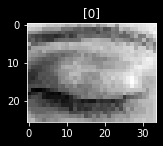

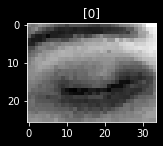

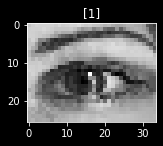

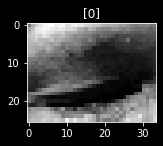

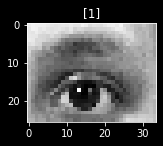

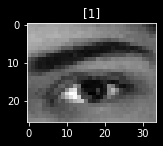

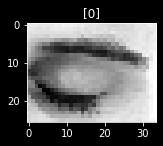

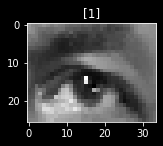

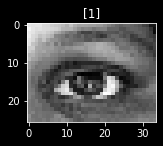

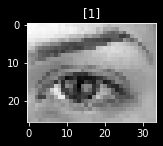

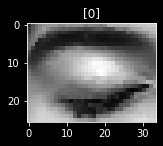

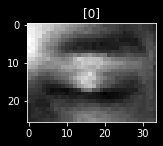

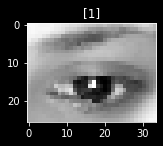

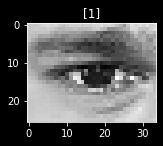

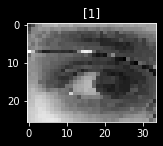

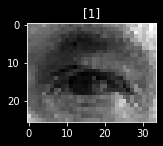

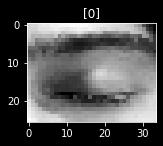

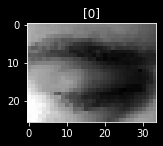

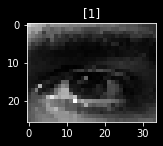

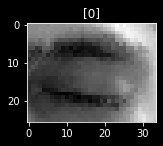

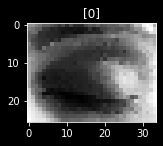

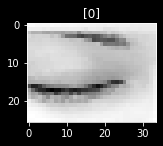

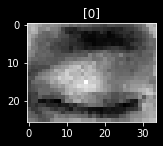

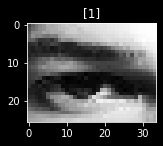

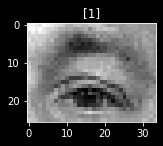

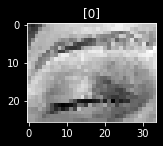

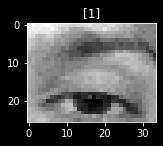

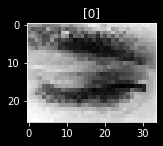

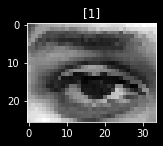

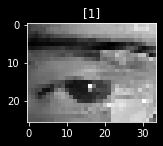

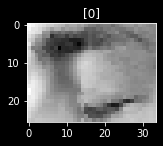

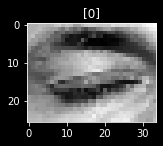

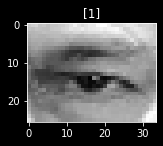

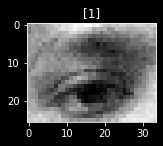

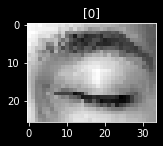

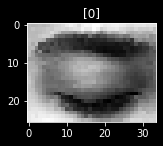

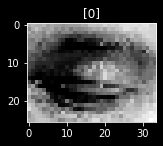

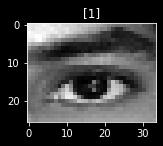

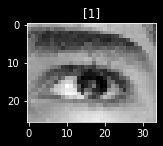

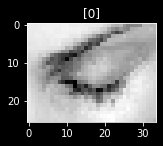

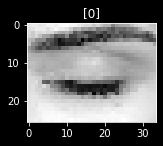

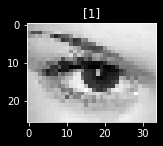

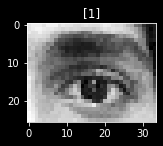

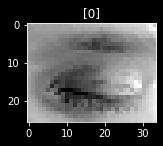

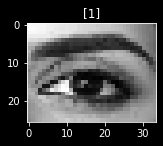

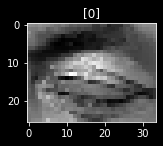

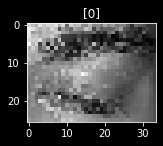

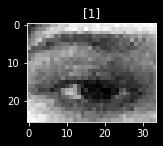

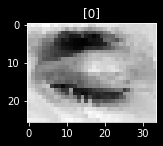

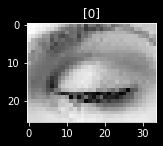

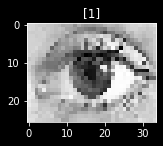

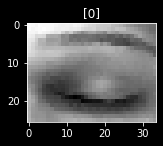

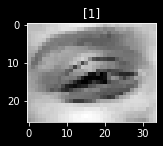

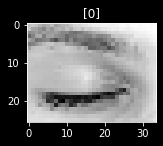

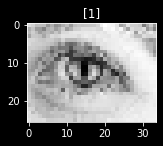

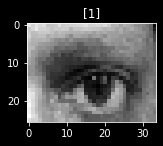

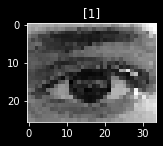

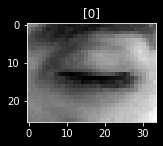

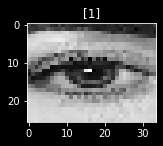

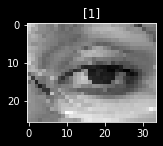

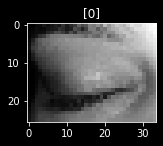

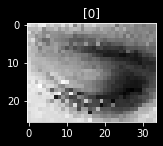

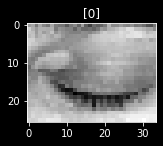

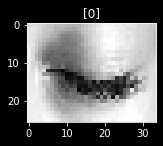

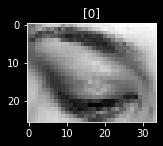

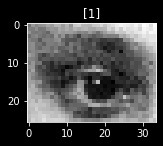

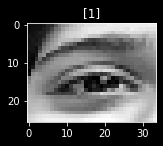

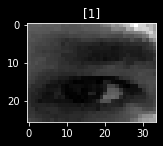

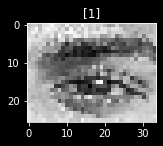

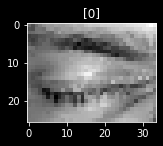

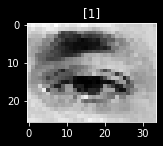

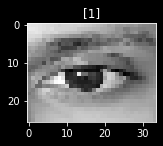

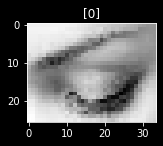

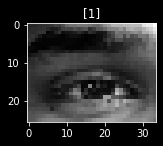

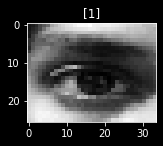

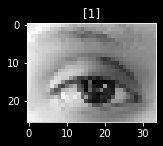

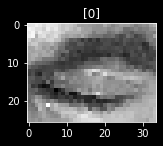

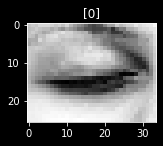

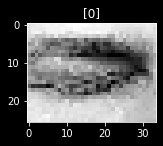

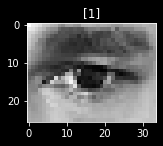

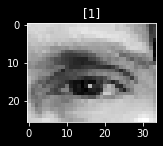

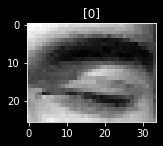

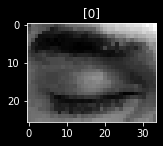

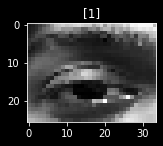

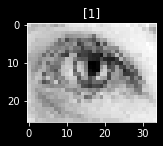

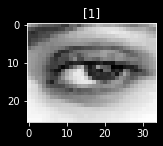

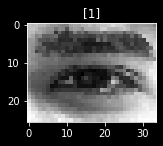

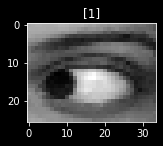

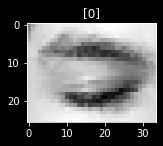

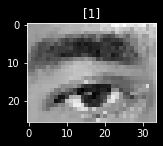

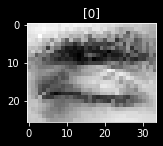

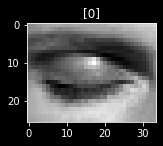

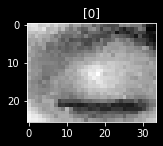

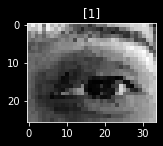

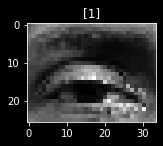

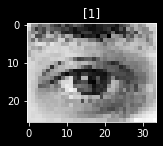

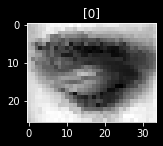

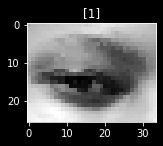

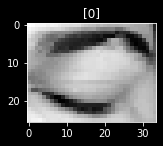

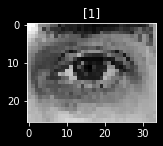

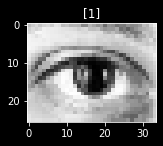

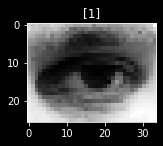

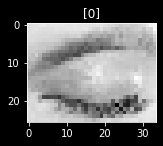

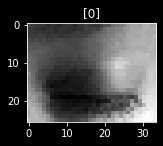

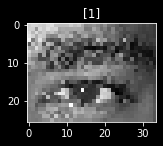

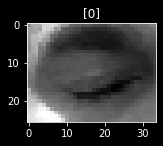

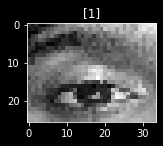

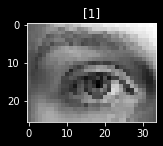

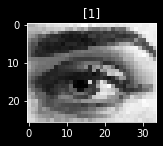

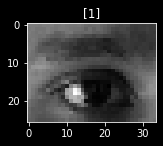

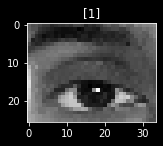

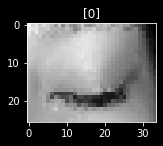

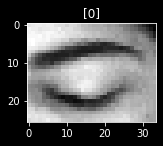

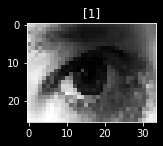

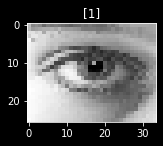

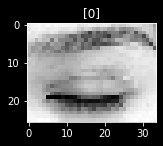

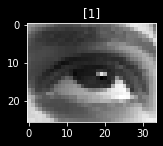

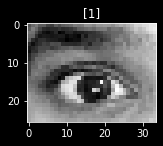

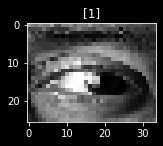

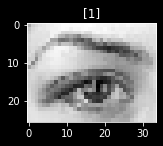

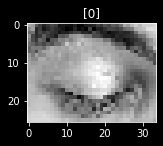

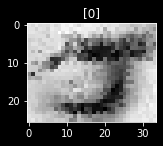

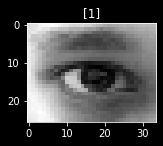

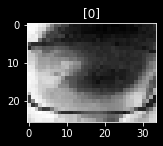

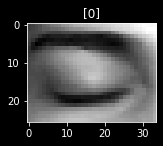

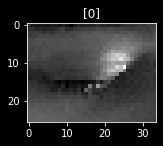

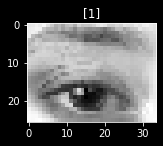

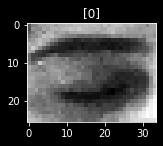

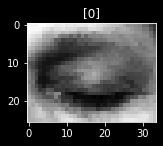

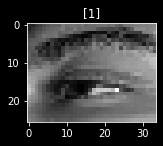

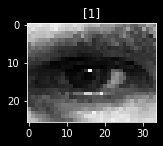

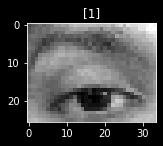

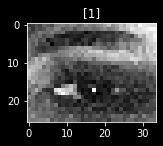

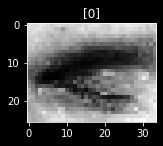

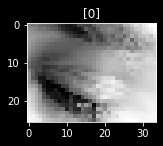

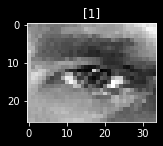

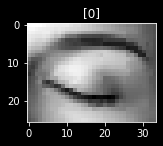

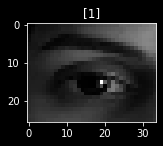

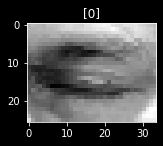

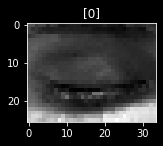

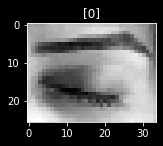

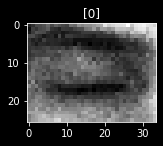

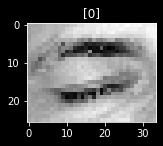

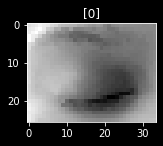

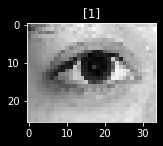

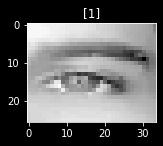

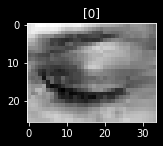

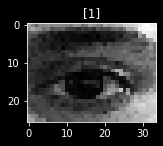

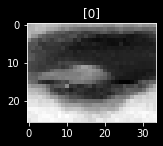

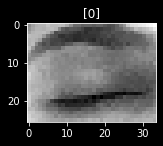

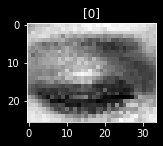

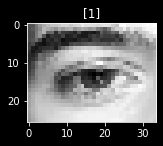

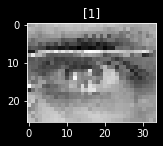

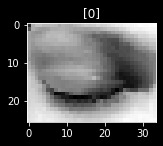

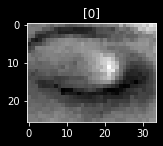

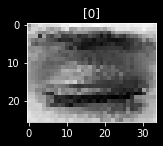

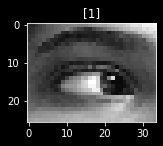

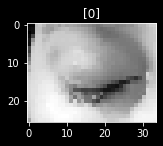

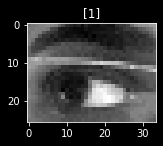

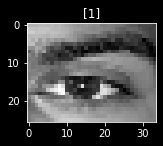

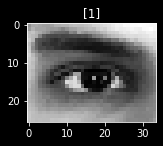

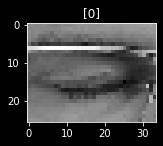

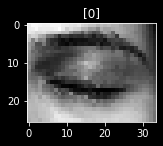

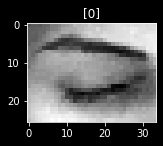

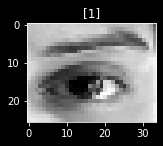

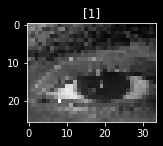

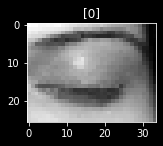

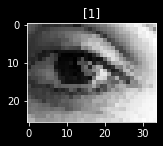

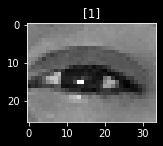

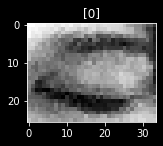

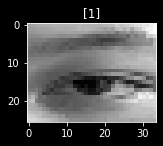

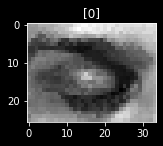

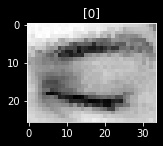

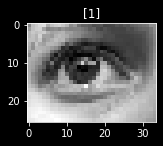

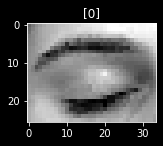

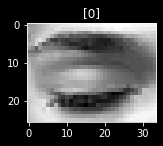

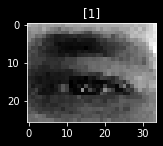

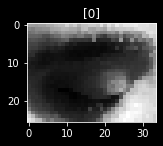

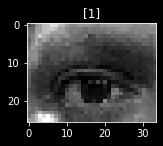

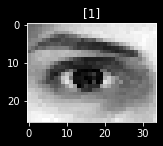

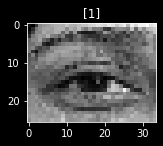

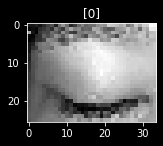

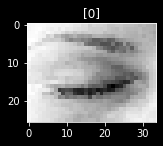

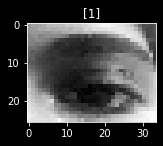

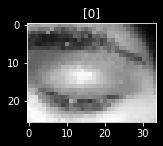

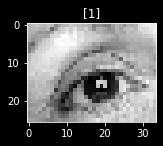

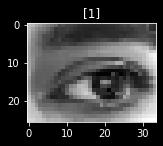

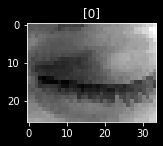

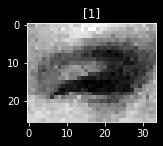

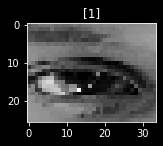

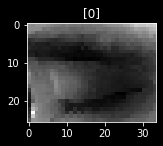

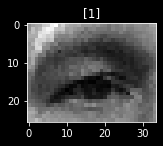

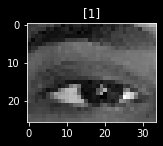

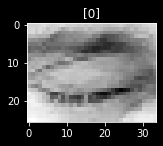

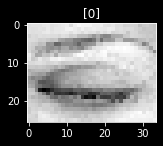

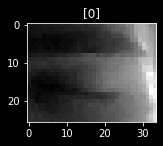

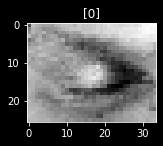

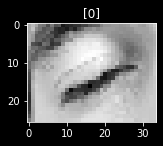

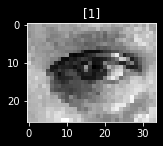

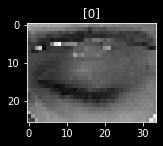

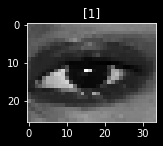

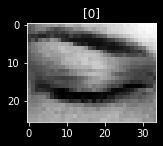

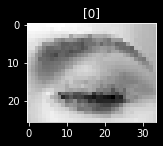

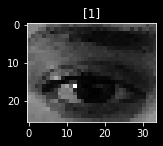

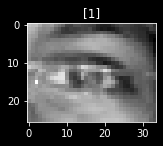

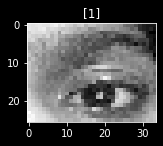

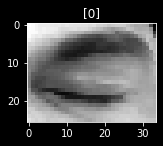

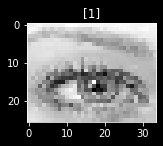

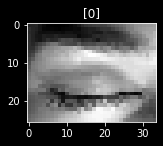

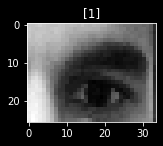

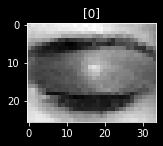

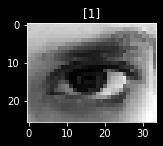

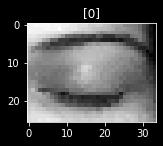

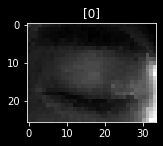

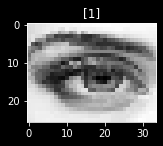

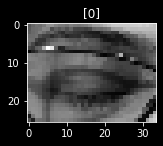

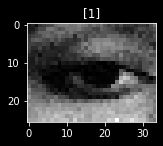

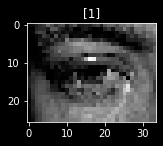

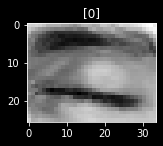

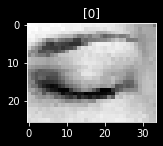

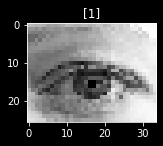

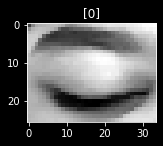

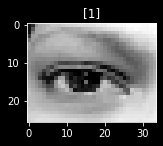

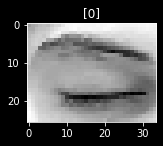

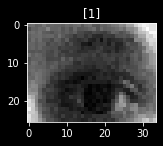

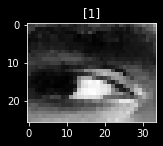

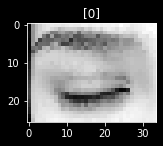

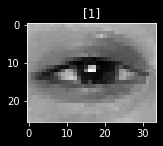

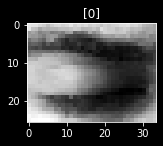

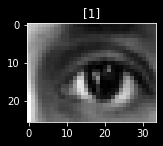

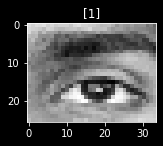

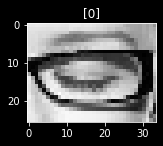

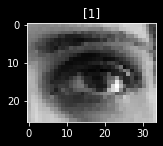

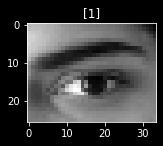

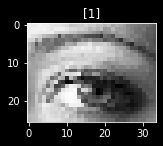

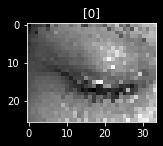

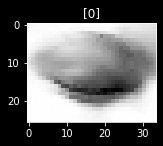

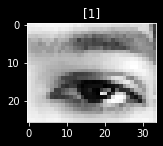

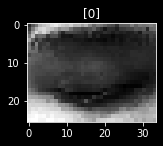

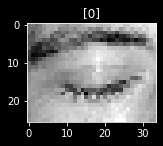

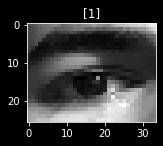

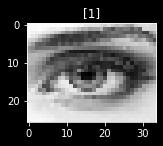

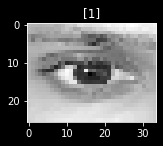

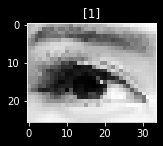

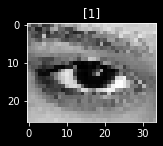

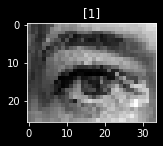

In [20]:
plt.style.use('dark_background')
fig = plt.figure()

for i in range(len(train_dataset)):
    x, y = train_dataset[i]

    plt.subplot(2, 1, 1)
    plt.title(str(y_train[i]))
    plt.imshow(X_train[i].reshape((26, 34)), cmap='gray')

    plt.show()

#### test

In [27]:
x_test.shape

(436, 26, 34, 1)

In [26]:
y_test.shape

(436, 1)

In [23]:
x_test = X_test  # (288, 26, 34, 1)
y_test = y_test  # (288, 1)

test_transform = transforms.Compose([
    transforms.ToTensor()
])

test_dataset = eyes_dataset(x_test, y_test, transform=test_transform)

test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4)

model = Net()
model.to('cuda')
model.eval()

count = 0

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [24]:
with torch.no_grad():
    total_acc = 0.0
    acc = 0.0
    for i, test_data in enumerate(test_dataloader, 0):
        data, labels = test_data[0].to('cuda'), test_data[1].to('cuda')

        data = data.transpose(1, 3).transpose(2, 3)

        outputs = model(data)

        acc = accuracy(outputs, labels)
        total_acc += acc

        count = i

    print('avarage acc: %.5f' % (total_acc/count),'%')

print('test finish!')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


avarage acc: 46.89655 %
test finish!
